##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Transfer learning and fine-tuning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb?force_kitty_mode=1&force_corgi_mode=1"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
#ignore warnings

import warnings
warnings.filterwarnings("ignore")

## Data preprocessing

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.utils.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


    8192/68606236 [..............................] - ETA: 0s


 5603328/68606236 [=>............................] - ETA: 0s


12271616/68606236 [====>.........................] - ETA: 0s


17883136/68606236 [======>.......................] - ETA: 0s


23166976/68606236 [=========>....................] - ETA: 0s


29212672/68606236 [===========>..................] - ETA: 0s


35725312/68606236 [==============>...............] - ETA: 0s


41680896/68606236 [=================>............] - ETA: 0s


47636480/68606236 [===================>..........] - ETA: 0s


52428800/68606236 [=====================>........] - ETA: 0s


56590336/68606236 [=======================>......] - ETA: 0s


62685184/68606236 [==========================>...] - ETA: 0s


68606236/68606236 [==============================] - 1s 0us/step


Found 2000 files belonging to 2 classes.


In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set:

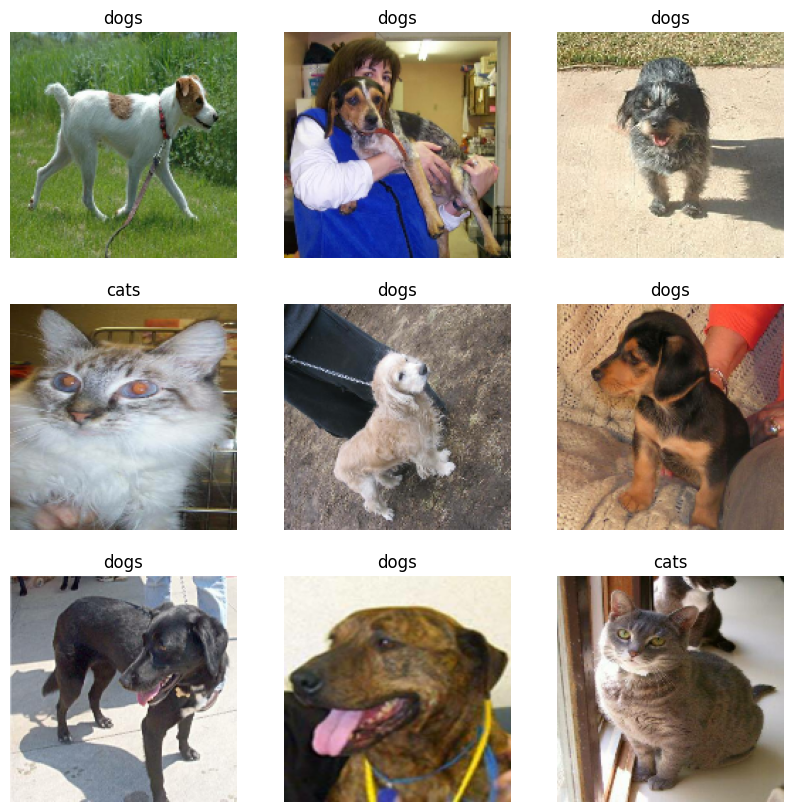

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate`, `Model.predict`, or `Model.call`.

Let's repeatedly apply these layers to the same image and see the result.

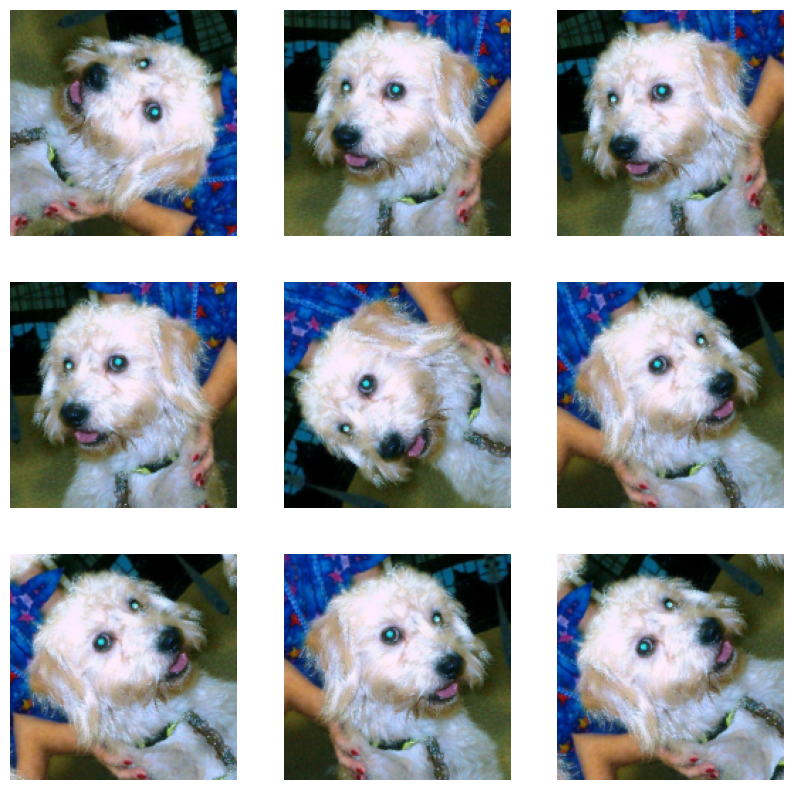

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [13]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [14]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


   8192/9406464 [..............................] - ETA: 0s


7430144/9406464 [======================>.......] - ETA: 0s


9406464/9406464 [==============================] - 0s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [16]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [17]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"


__________________________________________________________________________________________________


 Layer (type)                Output Shape                 Param #   Connected to                  


 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            


 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             


 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               


 on)                                                                                              


 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[0][0]']            


 expanded_conv_depthwise (D  (None, 80, 80, 32)           288       ['Conv1_relu[0][0]']          


 epthwiseConv2D)                                                                                  


 expanded_conv_depthwise_BN  (None, 80, 80, 32)           128       ['expanded_conv_depthwise[0][0


  (BatchNormalization)                                              ]']                           


 expanded_conv_depthwise_re  (None, 80, 80, 32)           0         ['expanded_conv_depthwise_BN[0


 lu (ReLU)                                                          ][0]']                        


 expanded_conv_project (Con  (None, 80, 80, 16)           512       ['expanded_conv_depthwise_relu


 v2D)                                                               [0][0]']                      


 expanded_conv_project_BN (  (None, 80, 80, 16)           64        ['expanded_conv_project[0][0]'


 BatchNormalization)                                                ]                             


 block_1_expand (Conv2D)     (None, 80, 80, 96)           1536      ['expanded_conv_project_BN[0][


                                                                    0]']                          


 block_1_expand_BN (BatchNo  (None, 80, 80, 96)           384       ['block_1_expand[0][0]']      


 rmalization)                                                                                     


 block_1_expand_relu (ReLU)  (None, 80, 80, 96)           0         ['block_1_expand_BN[0][0]']   


 block_1_pad (ZeroPadding2D  (None, 81, 81, 96)           0         ['block_1_expand_relu[0][0]'] 


 )                                                                                                


 block_1_depthwise (Depthwi  (None, 40, 40, 96)           864       ['block_1_pad[0][0]']         


 seConv2D)                                                                                        


 block_1_depthwise_BN (Batc  (None, 40, 40, 96)           384       ['block_1_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_1_depthwise_relu (Re  (None, 40, 40, 96)           0         ['block_1_depthwise_BN[0][0]']


 LU)                                                                                              


 block_1_project (Conv2D)    (None, 40, 40, 24)           2304      ['block_1_depthwise_relu[0][0]


                                                                    ']                            


 block_1_project_BN (BatchN  (None, 40, 40, 24)           96        ['block_1_project[0][0]']     


 ormalization)                                                                                    


 block_2_expand (Conv2D)     (None, 40, 40, 144)          3456      ['block_1_project_BN[0][0]']  


 block_2_expand_BN (BatchNo  (None, 40, 40, 144)          576       ['block_2_expand[0][0]']      


 rmalization)                                                                                     


 block_2_expand_relu (ReLU)  (None, 40, 40, 144)          0         ['block_2_expand_BN[0][0]']   


 block_2_depthwise (Depthwi  (None, 40, 40, 144)          1296      ['block_2_expand_relu[0][0]'] 


 seConv2D)                                                                                        


 block_2_depthwise_BN (Batc  (None, 40, 40, 144)          576       ['block_2_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_2_depthwise_relu (Re  (None, 40, 40, 144)          0         ['block_2_depthwise_BN[0][0]']


 LU)                                                                                              


 block_2_project (Conv2D)    (None, 40, 40, 24)           3456      ['block_2_depthwise_relu[0][0]


                                                                    ']                            


 block_2_project_BN (BatchN  (None, 40, 40, 24)           96        ['block_2_project[0][0]']     


 ormalization)                                                                                    


 block_2_add (Add)           (None, 40, 40, 24)           0         ['block_1_project_BN[0][0]',  


                                                                     'block_2_project_BN[0][0]']  


 block_3_expand (Conv2D)     (None, 40, 40, 144)          3456      ['block_2_add[0][0]']         


 block_3_expand_BN (BatchNo  (None, 40, 40, 144)          576       ['block_3_expand[0][0]']      


 rmalization)                                                                                     


 block_3_expand_relu (ReLU)  (None, 40, 40, 144)          0         ['block_3_expand_BN[0][0]']   


 block_3_pad (ZeroPadding2D  (None, 41, 41, 144)          0         ['block_3_expand_relu[0][0]'] 


 )                                                                                                


 block_3_depthwise (Depthwi  (None, 20, 20, 144)          1296      ['block_3_pad[0][0]']         


 seConv2D)                                                                                        


 block_3_depthwise_BN (Batc  (None, 20, 20, 144)          576       ['block_3_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_3_depthwise_relu (Re  (None, 20, 20, 144)          0         ['block_3_depthwise_BN[0][0]']


 LU)                                                                                              


 block_3_project (Conv2D)    (None, 20, 20, 32)           4608      ['block_3_depthwise_relu[0][0]


                                                                    ']                            


 block_3_project_BN (BatchN  (None, 20, 20, 32)           128       ['block_3_project[0][0]']     


 ormalization)                                                                                    


 block_4_expand (Conv2D)     (None, 20, 20, 192)          6144      ['block_3_project_BN[0][0]']  


 block_4_expand_BN (BatchNo  (None, 20, 20, 192)          768       ['block_4_expand[0][0]']      


 rmalization)                                                                                     


 block_4_expand_relu (ReLU)  (None, 20, 20, 192)          0         ['block_4_expand_BN[0][0]']   


 block_4_depthwise (Depthwi  (None, 20, 20, 192)          1728      ['block_4_expand_relu[0][0]'] 


 seConv2D)                                                                                        


 block_4_depthwise_BN (Batc  (None, 20, 20, 192)          768       ['block_4_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_4_depthwise_relu (Re  (None, 20, 20, 192)          0         ['block_4_depthwise_BN[0][0]']


 LU)                                                                                              


 block_4_project (Conv2D)    (None, 20, 20, 32)           6144      ['block_4_depthwise_relu[0][0]


                                                                    ']                            


 block_4_project_BN (BatchN  (None, 20, 20, 32)           128       ['block_4_project[0][0]']     


 ormalization)                                                                                    


 block_4_add (Add)           (None, 20, 20, 32)           0         ['block_3_project_BN[0][0]',  


                                                                     'block_4_project_BN[0][0]']  


 block_5_expand (Conv2D)     (None, 20, 20, 192)          6144      ['block_4_add[0][0]']         


 block_5_expand_BN (BatchNo  (None, 20, 20, 192)          768       ['block_5_expand[0][0]']      


 rmalization)                                                                                     


 block_5_expand_relu (ReLU)  (None, 20, 20, 192)          0         ['block_5_expand_BN[0][0]']   


 block_5_depthwise (Depthwi  (None, 20, 20, 192)          1728      ['block_5_expand_relu[0][0]'] 


 seConv2D)                                                                                        


 block_5_depthwise_BN (Batc  (None, 20, 20, 192)          768       ['block_5_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_5_depthwise_relu (Re  (None, 20, 20, 192)          0         ['block_5_depthwise_BN[0][0]']


 LU)                                                                                              


 block_5_project (Conv2D)    (None, 20, 20, 32)           6144      ['block_5_depthwise_relu[0][0]


                                                                    ']                            


 block_5_project_BN (BatchN  (None, 20, 20, 32)           128       ['block_5_project[0][0]']     


 ormalization)                                                                                    


 block_5_add (Add)           (None, 20, 20, 32)           0         ['block_4_add[0][0]',         


                                                                     'block_5_project_BN[0][0]']  


 block_6_expand (Conv2D)     (None, 20, 20, 192)          6144      ['block_5_add[0][0]']         


 block_6_expand_BN (BatchNo  (None, 20, 20, 192)          768       ['block_6_expand[0][0]']      


 rmalization)                                                                                     


 block_6_expand_relu (ReLU)  (None, 20, 20, 192)          0         ['block_6_expand_BN[0][0]']   


 block_6_pad (ZeroPadding2D  (None, 21, 21, 192)          0         ['block_6_expand_relu[0][0]'] 


 )                                                                                                


 block_6_depthwise (Depthwi  (None, 10, 10, 192)          1728      ['block_6_pad[0][0]']         


 seConv2D)                                                                                        


 block_6_depthwise_BN (Batc  (None, 10, 10, 192)          768       ['block_6_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_6_depthwise_relu (Re  (None, 10, 10, 192)          0         ['block_6_depthwise_BN[0][0]']


 LU)                                                                                              


 block_6_project (Conv2D)    (None, 10, 10, 64)           12288     ['block_6_depthwise_relu[0][0]


                                                                    ']                            


 block_6_project_BN (BatchN  (None, 10, 10, 64)           256       ['block_6_project[0][0]']     


 ormalization)                                                                                    


 block_7_expand (Conv2D)     (None, 10, 10, 384)          24576     ['block_6_project_BN[0][0]']  


 block_7_expand_BN (BatchNo  (None, 10, 10, 384)          1536      ['block_7_expand[0][0]']      


 rmalization)                                                                                     


 block_7_expand_relu (ReLU)  (None, 10, 10, 384)          0         ['block_7_expand_BN[0][0]']   


 block_7_depthwise (Depthwi  (None, 10, 10, 384)          3456      ['block_7_expand_relu[0][0]'] 


 seConv2D)                                                                                        


 block_7_depthwise_BN (Batc  (None, 10, 10, 384)          1536      ['block_7_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_7_depthwise_relu (Re  (None, 10, 10, 384)          0         ['block_7_depthwise_BN[0][0]']


 LU)                                                                                              


 block_7_project (Conv2D)    (None, 10, 10, 64)           24576     ['block_7_depthwise_relu[0][0]


                                                                    ']                            


 block_7_project_BN (BatchN  (None, 10, 10, 64)           256       ['block_7_project[0][0]']     


 ormalization)                                                                                    


 block_7_add (Add)           (None, 10, 10, 64)           0         ['block_6_project_BN[0][0]',  


                                                                     'block_7_project_BN[0][0]']  


 block_8_expand (Conv2D)     (None, 10, 10, 384)          24576     ['block_7_add[0][0]']         


 block_8_expand_BN (BatchNo  (None, 10, 10, 384)          1536      ['block_8_expand[0][0]']      


 rmalization)                                                                                     


 block_8_expand_relu (ReLU)  (None, 10, 10, 384)          0         ['block_8_expand_BN[0][0]']   


 block_8_depthwise (Depthwi  (None, 10, 10, 384)          3456      ['block_8_expand_relu[0][0]'] 


 seConv2D)                                                                                        


 block_8_depthwise_BN (Batc  (None, 10, 10, 384)          1536      ['block_8_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_8_depthwise_relu (Re  (None, 10, 10, 384)          0         ['block_8_depthwise_BN[0][0]']


 LU)                                                                                              


 block_8_project (Conv2D)    (None, 10, 10, 64)           24576     ['block_8_depthwise_relu[0][0]


                                                                    ']                            


 block_8_project_BN (BatchN  (None, 10, 10, 64)           256       ['block_8_project[0][0]']     


 ormalization)                                                                                    


 block_8_add (Add)           (None, 10, 10, 64)           0         ['block_7_add[0][0]',         


                                                                     'block_8_project_BN[0][0]']  


 block_9_expand (Conv2D)     (None, 10, 10, 384)          24576     ['block_8_add[0][0]']         


 block_9_expand_BN (BatchNo  (None, 10, 10, 384)          1536      ['block_9_expand[0][0]']      


 rmalization)                                                                                     


 block_9_expand_relu (ReLU)  (None, 10, 10, 384)          0         ['block_9_expand_BN[0][0]']   


 block_9_depthwise (Depthwi  (None, 10, 10, 384)          3456      ['block_9_expand_relu[0][0]'] 


 seConv2D)                                                                                        


 block_9_depthwise_BN (Batc  (None, 10, 10, 384)          1536      ['block_9_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_9_depthwise_relu (Re  (None, 10, 10, 384)          0         ['block_9_depthwise_BN[0][0]']


 LU)                                                                                              


 block_9_project (Conv2D)    (None, 10, 10, 64)           24576     ['block_9_depthwise_relu[0][0]


                                                                    ']                            


 block_9_project_BN (BatchN  (None, 10, 10, 64)           256       ['block_9_project[0][0]']     


 ormalization)                                                                                    


 block_9_add (Add)           (None, 10, 10, 64)           0         ['block_8_add[0][0]',         


                                                                     'block_9_project_BN[0][0]']  


 block_10_expand (Conv2D)    (None, 10, 10, 384)          24576     ['block_9_add[0][0]']         


 block_10_expand_BN (BatchN  (None, 10, 10, 384)          1536      ['block_10_expand[0][0]']     


 ormalization)                                                                                    


 block_10_expand_relu (ReLU  (None, 10, 10, 384)          0         ['block_10_expand_BN[0][0]']  


 )                                                                                                


 block_10_depthwise (Depthw  (None, 10, 10, 384)          3456      ['block_10_expand_relu[0][0]']


 iseConv2D)                                                                                       


 block_10_depthwise_BN (Bat  (None, 10, 10, 384)          1536      ['block_10_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_10_depthwise_relu (R  (None, 10, 10, 384)          0         ['block_10_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_10_project (Conv2D)   (None, 10, 10, 96)           36864     ['block_10_depthwise_relu[0][0


                                                                    ]']                           


 block_10_project_BN (Batch  (None, 10, 10, 96)           384       ['block_10_project[0][0]']    


 Normalization)                                                                                   


 block_11_expand (Conv2D)    (None, 10, 10, 576)          55296     ['block_10_project_BN[0][0]'] 


 block_11_expand_BN (BatchN  (None, 10, 10, 576)          2304      ['block_11_expand[0][0]']     


 ormalization)                                                                                    


 block_11_expand_relu (ReLU  (None, 10, 10, 576)          0         ['block_11_expand_BN[0][0]']  


 )                                                                                                


 block_11_depthwise (Depthw  (None, 10, 10, 576)          5184      ['block_11_expand_relu[0][0]']


 iseConv2D)                                                                                       


 block_11_depthwise_BN (Bat  (None, 10, 10, 576)          2304      ['block_11_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_11_depthwise_relu (R  (None, 10, 10, 576)          0         ['block_11_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_11_project (Conv2D)   (None, 10, 10, 96)           55296     ['block_11_depthwise_relu[0][0


                                                                    ]']                           


 block_11_project_BN (Batch  (None, 10, 10, 96)           384       ['block_11_project[0][0]']    


 Normalization)                                                                                   


 block_11_add (Add)          (None, 10, 10, 96)           0         ['block_10_project_BN[0][0]', 


                                                                     'block_11_project_BN[0][0]'] 


 block_12_expand (Conv2D)    (None, 10, 10, 576)          55296     ['block_11_add[0][0]']        


 block_12_expand_BN (BatchN  (None, 10, 10, 576)          2304      ['block_12_expand[0][0]']     


 ormalization)                                                                                    


 block_12_expand_relu (ReLU  (None, 10, 10, 576)          0         ['block_12_expand_BN[0][0]']  


 )                                                                                                


 block_12_depthwise (Depthw  (None, 10, 10, 576)          5184      ['block_12_expand_relu[0][0]']


 iseConv2D)                                                                                       


 block_12_depthwise_BN (Bat  (None, 10, 10, 576)          2304      ['block_12_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_12_depthwise_relu (R  (None, 10, 10, 576)          0         ['block_12_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_12_project (Conv2D)   (None, 10, 10, 96)           55296     ['block_12_depthwise_relu[0][0


                                                                    ]']                           


 block_12_project_BN (Batch  (None, 10, 10, 96)           384       ['block_12_project[0][0]']    


 Normalization)                                                                                   


 block_12_add (Add)          (None, 10, 10, 96)           0         ['block_11_add[0][0]',        


                                                                     'block_12_project_BN[0][0]'] 


 block_13_expand (Conv2D)    (None, 10, 10, 576)          55296     ['block_12_add[0][0]']        


 block_13_expand_BN (BatchN  (None, 10, 10, 576)          2304      ['block_13_expand[0][0]']     


 ormalization)                                                                                    


 block_13_expand_relu (ReLU  (None, 10, 10, 576)          0         ['block_13_expand_BN[0][0]']  


 )                                                                                                


 block_13_pad (ZeroPadding2  (None, 11, 11, 576)          0         ['block_13_expand_relu[0][0]']


 D)                                                                                               


 block_13_depthwise (Depthw  (None, 5, 5, 576)            5184      ['block_13_pad[0][0]']        


 iseConv2D)                                                                                       


 block_13_depthwise_BN (Bat  (None, 5, 5, 576)            2304      ['block_13_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_13_depthwise_relu (R  (None, 5, 5, 576)            0         ['block_13_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_13_project (Conv2D)   (None, 5, 5, 160)            92160     ['block_13_depthwise_relu[0][0


                                                                    ]']                           


 block_13_project_BN (Batch  (None, 5, 5, 160)            640       ['block_13_project[0][0]']    


 Normalization)                                                                                   


 block_14_expand (Conv2D)    (None, 5, 5, 960)            153600    ['block_13_project_BN[0][0]'] 


 block_14_expand_BN (BatchN  (None, 5, 5, 960)            3840      ['block_14_expand[0][0]']     


 ormalization)                                                                                    


 block_14_expand_relu (ReLU  (None, 5, 5, 960)            0         ['block_14_expand_BN[0][0]']  


 )                                                                                                


 block_14_depthwise (Depthw  (None, 5, 5, 960)            8640      ['block_14_expand_relu[0][0]']


 iseConv2D)                                                                                       


 block_14_depthwise_BN (Bat  (None, 5, 5, 960)            3840      ['block_14_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_14_depthwise_relu (R  (None, 5, 5, 960)            0         ['block_14_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_14_project (Conv2D)   (None, 5, 5, 160)            153600    ['block_14_depthwise_relu[0][0


                                                                    ]']                           


 block_14_project_BN (Batch  (None, 5, 5, 160)            640       ['block_14_project[0][0]']    


 Normalization)                                                                                   


 block_14_add (Add)          (None, 5, 5, 160)            0         ['block_13_project_BN[0][0]', 


                                                                     'block_14_project_BN[0][0]'] 


 block_15_expand (Conv2D)    (None, 5, 5, 960)            153600    ['block_14_add[0][0]']        


 block_15_expand_BN (BatchN  (None, 5, 5, 960)            3840      ['block_15_expand[0][0]']     


 ormalization)                                                                                    


 block_15_expand_relu (ReLU  (None, 5, 5, 960)            0         ['block_15_expand_BN[0][0]']  


 )                                                                                                


 block_15_depthwise (Depthw  (None, 5, 5, 960)            8640      ['block_15_expand_relu[0][0]']


 iseConv2D)                                                                                       


 block_15_depthwise_BN (Bat  (None, 5, 5, 960)            3840      ['block_15_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_15_depthwise_relu (R  (None, 5, 5, 960)            0         ['block_15_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_15_project (Conv2D)   (None, 5, 5, 160)            153600    ['block_15_depthwise_relu[0][0


                                                                    ]']                           


 block_15_project_BN (Batch  (None, 5, 5, 160)            640       ['block_15_project[0][0]']    


 Normalization)                                                                                   


 block_15_add (Add)          (None, 5, 5, 160)            0         ['block_14_add[0][0]',        


                                                                     'block_15_project_BN[0][0]'] 


 block_16_expand (Conv2D)    (None, 5, 5, 960)            153600    ['block_15_add[0][0]']        


 block_16_expand_BN (BatchN  (None, 5, 5, 960)            3840      ['block_16_expand[0][0]']     


 ormalization)                                                                                    


 block_16_expand_relu (ReLU  (None, 5, 5, 960)            0         ['block_16_expand_BN[0][0]']  


 )                                                                                                


 block_16_depthwise (Depthw  (None, 5, 5, 960)            8640      ['block_16_expand_relu[0][0]']


 iseConv2D)                                                                                       


 block_16_depthwise_BN (Bat  (None, 5, 5, 960)            3840      ['block_16_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_16_depthwise_relu (R  (None, 5, 5, 960)            0         ['block_16_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_16_project (Conv2D)   (None, 5, 5, 320)            307200    ['block_16_depthwise_relu[0][0


                                                                    ]']                           


 block_16_project_BN (Batch  (None, 5, 5, 320)            1280      ['block_16_project[0][0]']    


 Normalization)                                                                                   


 Conv_1 (Conv2D)             (None, 5, 5, 1280)           409600    ['block_16_project_BN[0][0]'] 


 Conv_1_bn (BatchNormalizat  (None, 5, 5, 1280)           5120      ['Conv_1[0][0]']              


 ion)                                                                                             


 out_relu (ReLU)             (None, 5, 5, 1280)           0         ['Conv_1_bn[0][0]']           


Total params: 2257984 (8.61 MB)


Trainable params: 0 (0.00 Byte)


Non-trainable params: 2257984 (8.61 MB)


__________________________________________________________________________________________________


### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [19]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [20]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
model.summary()

Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         


 sequential (Sequential)     (None, 160, 160, 3)       0         


 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         


 a)                                                              


 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         


 da)                                                             


 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   


 tional)                                                         


 global_average_pooling2d (  (None, 1280)              0         


 GlobalAveragePooling2D)                                         


 dropout (Dropout)           (None, 1280)              0         


 dense (Dense)               (None, 1)                 1281      


Total params: 2259265 (8.62 MB)


Trainable params: 1281 (5.00 KB)


Non-trainable params: 2257984 (8.61 MB)


_________________________________________________________________


The 8+ million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [22]:
len(model.trainable_variables)

2

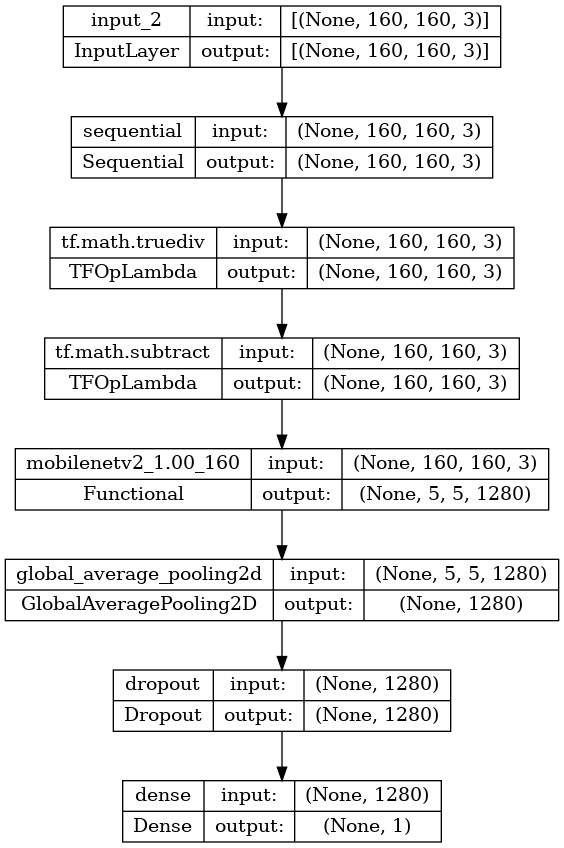

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Compile the model

Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

### Train the model

After training for 10 epochs, you should see ~96% accuracy on the validation set.


In [25]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)


 1/26 [>.............................] - ETA: 57s - loss: 0.6862 - accuracy: 0.6875


 4/26 [===>..........................] - ETA: 0s - loss: 0.6196 - accuracy: 0.6797 


 7/26 [=======>......................] - ETA: 0s - loss: 0.6286 - accuracy: 0.6741


10/26 [==========>...................] - ETA: 0s - loss: 0.6363 - accuracy: 0.6719


13/26 [==============>...............] - ETA: 0s - loss: 0.6206 - accuracy: 0.6827


16/26 [=================>............] - ETA: 0s - loss: 0.6377 - accuracy: 0.6602


19/26 [====================>.........] - ETA: 0s - loss: 0.6342 - accuracy: 0.6678


22/26 [========================>.....] - ETA: 0s - loss: 0.6360 - accuracy: 0.6719


25/26 [===========================>..] - ETA: 0s - loss: 0.6386 - accuracy: 0.6662


26/26 [==============================] - ETA: 0s - loss: 0.6389 - accuracy: 0.6646


26/26 [==============================] - 4s 56ms/step - loss: 0.6389 - accuracy: 0.6646


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.64
initial accuracy: 0.66


In [27]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10



 1/63 [..............................] - ETA: 3:53 - loss: 0.5853 - accuracy: 0.7500


 3/63 [>.............................] - ETA: 1s - loss: 0.6803 - accuracy: 0.6354  

I0000 00:00:1701916622.556633   26685 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



 5/63 [=>............................] - ETA: 1s - loss: 0.6965 - accuracy: 0.6313


 7/63 [==>...........................] - ETA: 1s - loss: 0.6775 - accuracy: 0.6429


 9/63 [===>..........................] - ETA: 1s - loss: 0.6504 - accuracy: 0.6562


11/63 [====>.........................] - ETA: 1s - loss: 0.6675 - accuracy: 0.6449


13/63 [=====>........................] - ETA: 1s - loss: 0.6544 - accuracy: 0.6442


15/63 [======>.......................] - ETA: 1s - loss: 0.6611 - accuracy: 0.6417


17/63 [=======>......................] - ETA: 1s - loss: 0.6604 - accuracy: 0.6379


19/63 [========>.....................] - ETA: 1s - loss: 0.6528 - accuracy: 0.6398


21/63 [=========>....................] - ETA: 1s - loss: 0.6433 - accuracy: 0.6458


23/63 [=========>....................] - ETA: 1s - loss: 0.6343 - accuracy: 0.6590


25/63 [==========>...................] - ETA: 1s - loss: 0.6312 - accuracy: 0.6600


28/63 [============>.................] - ETA: 0s - loss: 0.6249 - accuracy: 0.6685


30/63 [=============>................] - ETA: 0s - loss: 0.6177 - accuracy: 0.6760


32/63 [==============>...............] - ETA: 0s - loss: 0.6193 - accuracy: 0.6748


34/63 [===============>..............] - ETA: 0s - loss: 0.6197 - accuracy: 0.6746


36/63 [================>.............] - ETA: 0s - loss: 0.6191 - accuracy: 0.6736


39/63 [=================>............] - ETA: 0s - loss: 0.6148 - accuracy: 0.6787


41/63 [==================>...........] - ETA: 0s - loss: 0.6123 - accuracy: 0.6799


43/63 [===================>..........] - ETA: 0s - loss: 0.6058 - accuracy: 0.6839


46/63 [====================>.........] - ETA: 0s - loss: 0.6048 - accuracy: 0.6889


48/63 [=====================>........] - ETA: 0s - loss: 0.6035 - accuracy: 0.6908


50/63 [======================>.......] - ETA: 0s - loss: 0.6011 - accuracy: 0.6894


52/63 [=======================>......] - ETA: 0s - loss: 0.5975 - accuracy: 0.6923


55/63 [=========================>....] - ETA: 0s - loss: 0.5979 - accuracy: 0.6909


58/63 [==========================>...] - ETA: 0s - loss: 0.5905 - accuracy: 0.6961


61/63 [============================>.] - ETA: 0s - loss: 0.5878 - accuracy: 0.6988


63/63 [==============================] - ETA: 0s - loss: 0.5853 - accuracy: 0.7005


63/63 [==============================] - 7s 51ms/step - loss: 0.5853 - accuracy: 0.7005 - val_loss: 0.4511 - val_accuracy: 0.8342


Epoch 2/10



 1/63 [..............................] - ETA: 4s - loss: 0.5182 - accuracy: 0.7500


 3/63 [>.............................] - ETA: 1s - loss: 0.5140 - accuracy: 0.7500


 5/63 [=>............................] - ETA: 1s - loss: 0.4702 - accuracy: 0.7937


 7/63 [==>...........................] - ETA: 1s - loss: 0.4639 - accuracy: 0.8125


 9/63 [===>..........................] - ETA: 1s - loss: 0.4483 - accuracy: 0.8194


11/63 [====>.........................] - ETA: 1s - loss: 0.4607 - accuracy: 0.8040


13/63 [=====>........................] - ETA: 1s - loss: 0.4624 - accuracy: 0.7933


15/63 [======>.......................] - ETA: 1s - loss: 0.4656 - accuracy: 0.7917


17/63 [=======>......................] - ETA: 1s - loss: 0.4644 - accuracy: 0.7886


20/63 [========>.....................] - ETA: 1s - loss: 0.4657 - accuracy: 0.7953


22/63 [=========>....................] - ETA: 1s - loss: 0.4638 - accuracy: 0.7997


24/63 [==========>...................] - ETA: 0s - loss: 0.4592 - accuracy: 0.8021


26/63 [===========>..................] - ETA: 0s - loss: 0.4635 - accuracy: 0.8017


28/63 [============>.................] - ETA: 0s - loss: 0.4550 - accuracy: 0.8069


31/63 [=============>................] - ETA: 0s - loss: 0.4547 - accuracy: 0.8085


33/63 [==============>...............] - ETA: 0s - loss: 0.4523 - accuracy: 0.8116


35/63 [===============>..............] - ETA: 0s - loss: 0.4493 - accuracy: 0.8152


37/63 [================>.............] - ETA: 0s - loss: 0.4520 - accuracy: 0.8133


39/63 [=================>............] - ETA: 0s - loss: 0.4481 - accuracy: 0.8165


41/63 [==================>...........] - ETA: 0s - loss: 0.4524 - accuracy: 0.8140


43/63 [===================>..........] - ETA: 0s - loss: 0.4552 - accuracy: 0.8118


45/63 [====================>.........] - ETA: 0s - loss: 0.4546 - accuracy: 0.8097


48/63 [=====================>........] - ETA: 0s - loss: 0.4545 - accuracy: 0.8099


50/63 [======================>.......] - ETA: 0s - loss: 0.4551 - accuracy: 0.8100


52/63 [=======================>......] - ETA: 0s - loss: 0.4565 - accuracy: 0.8071


55/63 [=========================>....] - ETA: 0s - loss: 0.4543 - accuracy: 0.8074


58/63 [==========================>...] - ETA: 0s - loss: 0.4503 - accuracy: 0.8114


61/63 [============================>.] - ETA: 0s - loss: 0.4453 - accuracy: 0.8140


63/63 [==============================] - 2s 35ms/step - loss: 0.4433 - accuracy: 0.8155 - val_loss: 0.3250 - val_accuracy: 0.9072


Epoch 3/10



 1/63 [..............................] - ETA: 3s - loss: 0.4909 - accuracy: 0.8125


 3/63 [>.............................] - ETA: 1s - loss: 0.4174 - accuracy: 0.8229


 5/63 [=>............................] - ETA: 1s - loss: 0.3775 - accuracy: 0.8562


 7/63 [==>...........................] - ETA: 1s - loss: 0.3440 - accuracy: 0.8839


 9/63 [===>..........................] - ETA: 1s - loss: 0.3413 - accuracy: 0.8889


11/63 [====>.........................] - ETA: 1s - loss: 0.3396 - accuracy: 0.8835


13/63 [=====>........................] - ETA: 1s - loss: 0.3586 - accuracy: 0.8678


15/63 [======>.......................] - ETA: 1s - loss: 0.3519 - accuracy: 0.8750


17/63 [=======>......................] - ETA: 1s - loss: 0.3587 - accuracy: 0.8695


19/63 [========>.....................] - ETA: 1s - loss: 0.3690 - accuracy: 0.8651


21/63 [=========>....................] - ETA: 1s - loss: 0.3672 - accuracy: 0.8646


24/63 [==========>...................] - ETA: 0s - loss: 0.3693 - accuracy: 0.8646


26/63 [===========>..................] - ETA: 0s - loss: 0.3742 - accuracy: 0.8618


28/63 [============>.................] - ETA: 0s - loss: 0.3809 - accuracy: 0.8560


30/63 [=============>................] - ETA: 0s - loss: 0.3808 - accuracy: 0.8573


33/63 [==============>...............] - ETA: 0s - loss: 0.3745 - accuracy: 0.8636


35/63 [===============>..............] - ETA: 0s - loss: 0.3749 - accuracy: 0.8643


37/63 [================>.............] - ETA: 0s - loss: 0.3736 - accuracy: 0.8666


40/63 [==================>...........] - ETA: 0s - loss: 0.3722 - accuracy: 0.8656


42/63 [===================>..........] - ETA: 0s - loss: 0.3704 - accuracy: 0.8668


45/63 [====================>.........] - ETA: 0s - loss: 0.3704 - accuracy: 0.8667


47/63 [=====================>........] - ETA: 0s - loss: 0.3709 - accuracy: 0.8650


49/63 [======================>.......] - ETA: 0s - loss: 0.3696 - accuracy: 0.8673


51/63 [=======================>......] - ETA: 0s - loss: 0.3700 - accuracy: 0.8676


54/63 [========================>.....] - ETA: 0s - loss: 0.3715 - accuracy: 0.8657


57/63 [==========================>...] - ETA: 0s - loss: 0.3684 - accuracy: 0.8684


60/63 [===========================>..] - ETA: 0s - loss: 0.3651 - accuracy: 0.8698


63/63 [==============================] - ETA: 0s - loss: 0.3638 - accuracy: 0.8690


63/63 [==============================] - 2s 35ms/step - loss: 0.3638 - accuracy: 0.8690 - val_loss: 0.2563 - val_accuracy: 0.9418


Epoch 4/10



 1/63 [..............................] - ETA: 4s - loss: 0.2439 - accuracy: 0.9062


 3/63 [>.............................] - ETA: 1s - loss: 0.2955 - accuracy: 0.8750


 5/63 [=>............................] - ETA: 1s - loss: 0.3056 - accuracy: 0.8687


 7/63 [==>...........................] - ETA: 1s - loss: 0.2994 - accuracy: 0.8750


 9/63 [===>..........................] - ETA: 1s - loss: 0.2983 - accuracy: 0.8785


11/63 [====>.........................] - ETA: 1s - loss: 0.3107 - accuracy: 0.8750


13/63 [=====>........................] - ETA: 1s - loss: 0.3141 - accuracy: 0.8726


15/63 [======>.......................] - ETA: 1s - loss: 0.3244 - accuracy: 0.8646


17/63 [=======>......................] - ETA: 1s - loss: 0.3237 - accuracy: 0.8676


19/63 [========>.....................] - ETA: 1s - loss: 0.3273 - accuracy: 0.8668


21/63 [=========>....................] - ETA: 1s - loss: 0.3311 - accuracy: 0.8661


23/63 [=========>....................] - ETA: 1s - loss: 0.3419 - accuracy: 0.8587


25/63 [==========>...................] - ETA: 0s - loss: 0.3344 - accuracy: 0.8662


27/63 [===========>..................] - ETA: 0s - loss: 0.3323 - accuracy: 0.8669


29/63 [============>.................] - ETA: 0s - loss: 0.3315 - accuracy: 0.8685


31/63 [=============>................] - ETA: 0s - loss: 0.3300 - accuracy: 0.8700


33/63 [==============>...............] - ETA: 0s - loss: 0.3333 - accuracy: 0.8684


36/63 [================>.............] - ETA: 0s - loss: 0.3338 - accuracy: 0.8698


38/63 [=================>............] - ETA: 0s - loss: 0.3335 - accuracy: 0.8709


41/63 [==================>...........] - ETA: 0s - loss: 0.3346 - accuracy: 0.8704


44/63 [===================>..........] - ETA: 0s - loss: 0.3314 - accuracy: 0.8707


46/63 [====================>.........] - ETA: 0s - loss: 0.3359 - accuracy: 0.8682


48/63 [=====================>........] - ETA: 0s - loss: 0.3316 - accuracy: 0.8724


50/63 [======================>.......] - ETA: 0s - loss: 0.3325 - accuracy: 0.8731


52/63 [=======================>......] - ETA: 0s - loss: 0.3278 - accuracy: 0.8756


55/63 [=========================>....] - ETA: 0s - loss: 0.3261 - accuracy: 0.8767


58/63 [==========================>...] - ETA: 0s - loss: 0.3221 - accuracy: 0.8782


61/63 [============================>.] - ETA: 0s - loss: 0.3201 - accuracy: 0.8791


63/63 [==============================] - 2s 35ms/step - loss: 0.3177 - accuracy: 0.8800 - val_loss: 0.2155 - val_accuracy: 0.9480


Epoch 5/10



 1/63 [..............................] - ETA: 3s - loss: 0.1957 - accuracy: 1.0000


 3/63 [>.............................] - ETA: 1s - loss: 0.2706 - accuracy: 0.9479


 5/63 [=>............................] - ETA: 1s - loss: 0.2813 - accuracy: 0.9125


 8/63 [==>...........................] - ETA: 1s - loss: 0.2774 - accuracy: 0.9180


10/63 [===>..........................] - ETA: 1s - loss: 0.2669 - accuracy: 0.9219


12/63 [====>.........................] - ETA: 1s - loss: 0.2623 - accuracy: 0.9219


15/63 [======>.......................] - ETA: 1s - loss: 0.2762 - accuracy: 0.9021


17/63 [=======>......................] - ETA: 1s - loss: 0.2818 - accuracy: 0.8971


20/63 [========>.....................] - ETA: 1s - loss: 0.2874 - accuracy: 0.8875


22/63 [=========>....................] - ETA: 1s - loss: 0.2888 - accuracy: 0.8849


24/63 [==========>...................] - ETA: 0s - loss: 0.2815 - accuracy: 0.8867


26/63 [===========>..................] - ETA: 0s - loss: 0.2835 - accuracy: 0.8858


28/63 [============>.................] - ETA: 0s - loss: 0.2823 - accuracy: 0.8884


30/63 [=============>................] - ETA: 0s - loss: 0.2830 - accuracy: 0.8896


32/63 [==============>...............] - ETA: 0s - loss: 0.2853 - accuracy: 0.8896


34/63 [===============>..............] - ETA: 0s - loss: 0.2841 - accuracy: 0.8897


36/63 [================>.............] - ETA: 0s - loss: 0.2856 - accuracy: 0.8889


39/63 [=================>............] - ETA: 0s - loss: 0.2847 - accuracy: 0.8886


41/63 [==================>...........] - ETA: 0s - loss: 0.2815 - accuracy: 0.8918


43/63 [===================>..........] - ETA: 0s - loss: 0.2802 - accuracy: 0.8924


45/63 [====================>.........] - ETA: 0s - loss: 0.2791 - accuracy: 0.8924


47/63 [=====================>........] - ETA: 0s - loss: 0.2771 - accuracy: 0.8943


50/63 [======================>.......] - ETA: 0s - loss: 0.2766 - accuracy: 0.8938


52/63 [=======================>......] - ETA: 0s - loss: 0.2738 - accuracy: 0.8960


55/63 [=========================>....] - ETA: 0s - loss: 0.2795 - accuracy: 0.8932


58/63 [==========================>...] - ETA: 0s - loss: 0.2800 - accuracy: 0.8922


61/63 [============================>.] - ETA: 0s - loss: 0.2771 - accuracy: 0.8934


63/63 [==============================] - 2s 35ms/step - loss: 0.2762 - accuracy: 0.8945 - val_loss: 0.1849 - val_accuracy: 0.9530


Epoch 6/10



 1/63 [..............................] - ETA: 3s - loss: 0.2592 - accuracy: 0.8750


 3/63 [>.............................] - ETA: 1s - loss: 0.2454 - accuracy: 0.9167


 5/63 [=>............................] - ETA: 1s - loss: 0.2943 - accuracy: 0.8875


 7/63 [==>...........................] - ETA: 1s - loss: 0.2597 - accuracy: 0.9107


 9/63 [===>..........................] - ETA: 1s - loss: 0.2577 - accuracy: 0.9132


11/63 [====>.........................] - ETA: 1s - loss: 0.2566 - accuracy: 0.9148


14/63 [=====>........................] - ETA: 1s - loss: 0.2618 - accuracy: 0.9085


16/63 [======>.......................] - ETA: 1s - loss: 0.2574 - accuracy: 0.9102


18/63 [=======>......................] - ETA: 1s - loss: 0.2723 - accuracy: 0.8976


21/63 [=========>....................] - ETA: 1s - loss: 0.2714 - accuracy: 0.9018


23/63 [=========>....................] - ETA: 1s - loss: 0.2700 - accuracy: 0.9008


25/63 [==========>...................] - ETA: 0s - loss: 0.2697 - accuracy: 0.9000


27/63 [===========>..................] - ETA: 0s - loss: 0.2695 - accuracy: 0.9028


30/63 [=============>................] - ETA: 0s - loss: 0.2700 - accuracy: 0.9042


33/63 [==============>...............] - ETA: 0s - loss: 0.2737 - accuracy: 0.8958


35/63 [===============>..............] - ETA: 0s - loss: 0.2727 - accuracy: 0.8964


38/63 [=================>............] - ETA: 0s - loss: 0.2709 - accuracy: 0.8980


40/63 [==================>...........] - ETA: 0s - loss: 0.2710 - accuracy: 0.8984


43/63 [===================>..........] - ETA: 0s - loss: 0.2688 - accuracy: 0.8975


45/63 [====================>.........] - ETA: 0s - loss: 0.2701 - accuracy: 0.8972


47/63 [=====================>........] - ETA: 0s - loss: 0.2701 - accuracy: 0.8963


50/63 [======================>.......] - ETA: 0s - loss: 0.2699 - accuracy: 0.8956


53/63 [========================>.....] - ETA: 0s - loss: 0.2673 - accuracy: 0.8968


56/63 [=========================>....] - ETA: 0s - loss: 0.2650 - accuracy: 0.9001


59/63 [===========================>..] - ETA: 0s - loss: 0.2658 - accuracy: 0.8999


62/63 [============================>.] - ETA: 0s - loss: 0.2646 - accuracy: 0.9002


63/63 [==============================] - 2s 35ms/step - loss: 0.2636 - accuracy: 0.9005 - val_loss: 0.1658 - val_accuracy: 0.9567


Epoch 7/10



 1/63 [..............................] - ETA: 3s - loss: 0.1916 - accuracy: 0.9688


 3/63 [>.............................] - ETA: 1s - loss: 0.2458 - accuracy: 0.9271


 5/63 [=>............................] - ETA: 1s - loss: 0.2199 - accuracy: 0.9438


 7/63 [==>...........................] - ETA: 1s - loss: 0.2218 - accuracy: 0.9420


 9/63 [===>..........................] - ETA: 1s - loss: 0.2218 - accuracy: 0.9375


11/63 [====>.........................] - ETA: 1s - loss: 0.2228 - accuracy: 0.9318


13/63 [=====>........................] - ETA: 1s - loss: 0.2284 - accuracy: 0.9255


15/63 [======>.......................] - ETA: 1s - loss: 0.2297 - accuracy: 0.9250


17/63 [=======>......................] - ETA: 1s - loss: 0.2275 - accuracy: 0.9228


19/63 [========>.....................] - ETA: 1s - loss: 0.2392 - accuracy: 0.9128


21/63 [=========>....................] - ETA: 1s - loss: 0.2415 - accuracy: 0.9107


23/63 [=========>....................] - ETA: 1s - loss: 0.2500 - accuracy: 0.9062


25/63 [==========>...................] - ETA: 0s - loss: 0.2465 - accuracy: 0.9050


27/63 [===========>..................] - ETA: 0s - loss: 0.2417 - accuracy: 0.9097


29/63 [============>.................] - ETA: 0s - loss: 0.2440 - accuracy: 0.9095


31/63 [=============>................] - ETA: 0s - loss: 0.2430 - accuracy: 0.9113


33/63 [==============>...............] - ETA: 0s - loss: 0.2450 - accuracy: 0.9100


35/63 [===============>..............] - ETA: 0s - loss: 0.2411 - accuracy: 0.9125


37/63 [================>.............] - ETA: 0s - loss: 0.2439 - accuracy: 0.9096


39/63 [=================>............] - ETA: 0s - loss: 0.2479 - accuracy: 0.9079


41/63 [==================>...........] - ETA: 0s - loss: 0.2483 - accuracy: 0.9062


43/63 [===================>..........] - ETA: 0s - loss: 0.2471 - accuracy: 0.9062


45/63 [====================>.........] - ETA: 0s - loss: 0.2496 - accuracy: 0.9049


48/63 [=====================>........] - ETA: 0s - loss: 0.2480 - accuracy: 0.9049


50/63 [======================>.......] - ETA: 0s - loss: 0.2489 - accuracy: 0.9038


53/63 [========================>.....] - ETA: 0s - loss: 0.2491 - accuracy: 0.9015


56/63 [=========================>....] - ETA: 0s - loss: 0.2499 - accuracy: 0.9018


59/63 [===========================>..] - ETA: 0s - loss: 0.2460 - accuracy: 0.9025


62/63 [============================>.] - ETA: 0s - loss: 0.2442 - accuracy: 0.9047


63/63 [==============================] - 2s 35ms/step - loss: 0.2436 - accuracy: 0.9055 - val_loss: 0.1535 - val_accuracy: 0.9616


Epoch 8/10



 1/63 [..............................] - ETA: 3s - loss: 0.2840 - accuracy: 0.9062


 3/63 [>.............................] - ETA: 1s - loss: 0.2154 - accuracy: 0.9375


 5/63 [=>............................] - ETA: 1s - loss: 0.2213 - accuracy: 0.9250


 7/63 [==>...........................] - ETA: 1s - loss: 0.2214 - accuracy: 0.9241


 9/63 [===>..........................] - ETA: 1s - loss: 0.2391 - accuracy: 0.9132


12/63 [====>.........................] - ETA: 1s - loss: 0.2250 - accuracy: 0.9141


14/63 [=====>........................] - ETA: 1s - loss: 0.2256 - accuracy: 0.9107


16/63 [======>.......................] - ETA: 1s - loss: 0.2275 - accuracy: 0.9102


19/63 [========>.....................] - ETA: 1s - loss: 0.2317 - accuracy: 0.9062


21/63 [=========>....................] - ETA: 1s - loss: 0.2370 - accuracy: 0.9033


23/63 [=========>....................] - ETA: 1s - loss: 0.2368 - accuracy: 0.9022


25/63 [==========>...................] - ETA: 0s - loss: 0.2399 - accuracy: 0.9025


27/63 [===========>..................] - ETA: 0s - loss: 0.2389 - accuracy: 0.9028


30/63 [=============>................] - ETA: 0s - loss: 0.2390 - accuracy: 0.9021


32/63 [==============>...............] - ETA: 0s - loss: 0.2419 - accuracy: 0.9014


34/63 [===============>..............] - ETA: 0s - loss: 0.2431 - accuracy: 0.9007


36/63 [================>.............] - ETA: 0s - loss: 0.2395 - accuracy: 0.9019


38/63 [=================>............] - ETA: 0s - loss: 0.2391 - accuracy: 0.9021


41/63 [==================>...........] - ETA: 0s - loss: 0.2386 - accuracy: 0.9017


43/63 [===================>..........] - ETA: 0s - loss: 0.2383 - accuracy: 0.9026


45/63 [====================>.........] - ETA: 0s - loss: 0.2372 - accuracy: 0.9035


47/63 [=====================>........] - ETA: 0s - loss: 0.2352 - accuracy: 0.9056


49/63 [======================>.......] - ETA: 0s - loss: 0.2356 - accuracy: 0.9037


51/63 [=======================>......] - ETA: 0s - loss: 0.2367 - accuracy: 0.9013


54/63 [========================>.....] - ETA: 0s - loss: 0.2334 - accuracy: 0.9039


57/63 [==========================>...] - ETA: 0s - loss: 0.2327 - accuracy: 0.9041


60/63 [===========================>..] - ETA: 0s - loss: 0.2288 - accuracy: 0.9078


63/63 [==============================] - ETA: 0s - loss: 0.2301 - accuracy: 0.9065


63/63 [==============================] - 2s 35ms/step - loss: 0.2301 - accuracy: 0.9065 - val_loss: 0.1384 - val_accuracy: 0.9653


Epoch 9/10



 1/63 [..............................] - ETA: 3s - loss: 0.2140 - accuracy: 0.9062


 3/63 [>.............................] - ETA: 1s - loss: 0.2126 - accuracy: 0.9375


 5/63 [=>............................] - ETA: 1s - loss: 0.2445 - accuracy: 0.9000


 7/63 [==>...........................] - ETA: 1s - loss: 0.2164 - accuracy: 0.9107


 9/63 [===>..........................] - ETA: 1s - loss: 0.2174 - accuracy: 0.9132


11/63 [====>.........................] - ETA: 1s - loss: 0.2111 - accuracy: 0.9205


13/63 [=====>........................] - ETA: 1s - loss: 0.2099 - accuracy: 0.9183


16/63 [======>.......................] - ETA: 1s - loss: 0.2069 - accuracy: 0.9219


18/63 [=======>......................] - ETA: 1s - loss: 0.2132 - accuracy: 0.9167


21/63 [=========>....................] - ETA: 1s - loss: 0.2130 - accuracy: 0.9182


23/63 [=========>....................] - ETA: 1s - loss: 0.2102 - accuracy: 0.9198


26/63 [===========>..................] - ETA: 0s - loss: 0.2079 - accuracy: 0.9207


28/63 [============>.................] - ETA: 0s - loss: 0.2076 - accuracy: 0.9208


31/63 [=============>................] - ETA: 0s - loss: 0.2088 - accuracy: 0.9224


34/63 [===============>..............] - ETA: 0s - loss: 0.2096 - accuracy: 0.9219


37/63 [================>.............] - ETA: 0s - loss: 0.2091 - accuracy: 0.9198


39/63 [=================>............] - ETA: 0s - loss: 0.2096 - accuracy: 0.9199


41/63 [==================>...........] - ETA: 0s - loss: 0.2052 - accuracy: 0.9230


43/63 [===================>..........] - ETA: 0s - loss: 0.2051 - accuracy: 0.9244


45/63 [====================>.........] - ETA: 0s - loss: 0.2046 - accuracy: 0.9250


48/63 [=====================>........] - ETA: 0s - loss: 0.2069 - accuracy: 0.9245


51/63 [=======================>......] - ETA: 0s - loss: 0.2070 - accuracy: 0.9246


54/63 [========================>.....] - ETA: 0s - loss: 0.2071 - accuracy: 0.9242


57/63 [==========================>...] - ETA: 0s - loss: 0.2069 - accuracy: 0.9249


60/63 [===========================>..] - ETA: 0s - loss: 0.2057 - accuracy: 0.9250


63/63 [==============================] - ETA: 0s - loss: 0.2026 - accuracy: 0.9260


63/63 [==============================] - 2s 35ms/step - loss: 0.2026 - accuracy: 0.9260 - val_loss: 0.1294 - val_accuracy: 0.9666


Epoch 10/10



 1/63 [..............................] - ETA: 3s - loss: 0.1252 - accuracy: 0.9688


 3/63 [>.............................] - ETA: 1s - loss: 0.1723 - accuracy: 0.9583


 5/63 [=>............................] - ETA: 1s - loss: 0.1512 - accuracy: 0.9688


 7/63 [==>...........................] - ETA: 1s - loss: 0.1641 - accuracy: 0.9598


 9/63 [===>..........................] - ETA: 1s - loss: 0.1595 - accuracy: 0.9549


11/63 [====>.........................] - ETA: 1s - loss: 0.1746 - accuracy: 0.9489


13/63 [=====>........................] - ETA: 1s - loss: 0.1786 - accuracy: 0.9423


16/63 [======>.......................] - ETA: 1s - loss: 0.1914 - accuracy: 0.9297


18/63 [=======>......................] - ETA: 1s - loss: 0.1971 - accuracy: 0.9271


21/63 [=========>....................] - ETA: 1s - loss: 0.1925 - accuracy: 0.9301


23/63 [=========>....................] - ETA: 1s - loss: 0.1927 - accuracy: 0.9280


25/63 [==========>...................] - ETA: 0s - loss: 0.1975 - accuracy: 0.9262


27/63 [===========>..................] - ETA: 0s - loss: 0.1992 - accuracy: 0.9259


30/63 [=============>................] - ETA: 0s - loss: 0.2078 - accuracy: 0.9219


33/63 [==============>...............] - ETA: 0s - loss: 0.2066 - accuracy: 0.9214


36/63 [================>.............] - ETA: 0s - loss: 0.2059 - accuracy: 0.9210


38/63 [=================>............] - ETA: 0s - loss: 0.2048 - accuracy: 0.9227


40/63 [==================>...........] - ETA: 0s - loss: 0.2034 - accuracy: 0.9242


43/63 [===================>..........] - ETA: 0s - loss: 0.2005 - accuracy: 0.9266


45/63 [====================>.........] - ETA: 0s - loss: 0.2005 - accuracy: 0.9271


47/63 [=====================>........] - ETA: 0s - loss: 0.1999 - accuracy: 0.9282


49/63 [======================>.......] - ETA: 0s - loss: 0.1989 - accuracy: 0.9279


51/63 [=======================>......] - ETA: 0s - loss: 0.2012 - accuracy: 0.9259


54/63 [========================>.....] - ETA: 0s - loss: 0.2030 - accuracy: 0.9248


57/63 [==========================>...] - ETA: 0s - loss: 0.1995 - accuracy: 0.9265


60/63 [===========================>..] - ETA: 0s - loss: 0.2000 - accuracy: 0.9255


63/63 [==============================] - ETA: 0s - loss: 0.2033 - accuracy: 0.9240


63/63 [==============================] - 2s 35ms/step - loss: 0.2033 - accuracy: 0.9240 - val_loss: 0.1199 - val_accuracy: 0.9691


### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

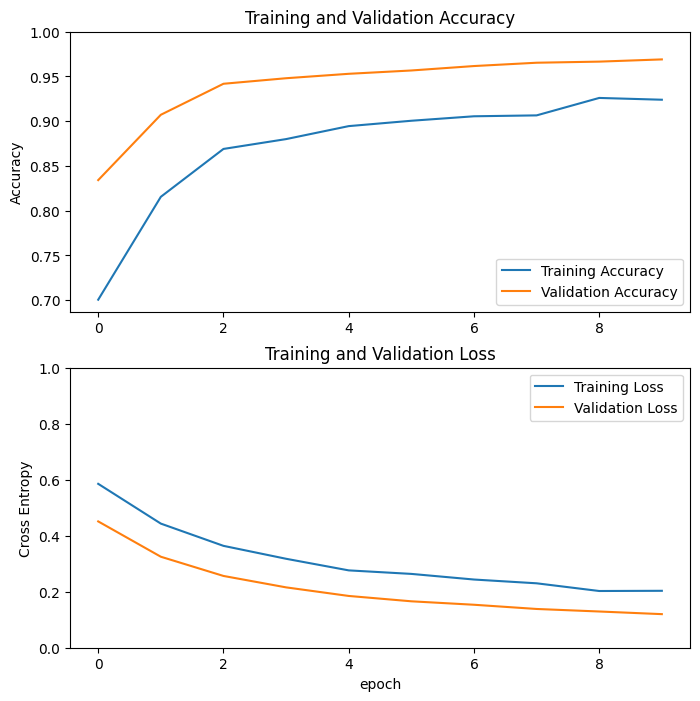

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [29]:
base_model.trainable = True

In [30]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [31]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [32]:
model.summary()

Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         


 sequential (Sequential)     (None, 160, 160, 3)       0         


 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         


 a)                                                              


 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         


 da)                                                             


 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   


 tional)                                                         


 global_average_pooling2d (  (None, 1280)              0         


 GlobalAveragePooling2D)                                         


 dropout (Dropout)           (None, 1280)              0         


 dense (Dense)               (None, 1)                 1281      


Total params: 2259265 (8.62 MB)


Trainable params: 1862721 (7.11 MB)


Non-trainable params: 396544 (1.51 MB)


_________________________________________________________________


In [33]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [34]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20



 1/63 [..............................] - ETA: 7:53 - loss: 0.1790 - accuracy: 0.9375


 3/63 [>.............................] - ETA: 2s - loss: 0.2936 - accuracy: 0.8542  


 5/63 [=>............................] - ETA: 2s - loss: 0.2559 - accuracy: 0.8875


 7/63 [==>...........................] - ETA: 2s - loss: 0.2132 - accuracy: 0.9152


 9/63 [===>..........................] - ETA: 2s - loss: 0.2014 - accuracy: 0.9201


11/63 [====>.........................] - ETA: 2s - loss: 0.1824 - accuracy: 0.9290


13/63 [=====>........................] - ETA: 1s - loss: 0.1711 - accuracy: 0.9351


15/63 [======>.......................] - ETA: 1s - loss: 0.1698 - accuracy: 0.9354


17/63 [=======>......................] - ETA: 1s - loss: 0.1762 - accuracy: 0.9301


19/63 [========>.....................] - ETA: 1s - loss: 0.1676 - accuracy: 0.9342


21/63 [=========>....................] - ETA: 1s - loss: 0.1644 - accuracy: 0.9360


23/63 [=========>....................] - ETA: 1s - loss: 0.1598 - accuracy: 0.9389


25/63 [==========>...................] - ETA: 1s - loss: 0.1584 - accuracy: 0.9400


27/63 [===========>..................] - ETA: 1s - loss: 0.1620 - accuracy: 0.9375


29/63 [============>.................] - ETA: 1s - loss: 0.1821 - accuracy: 0.9256


31/63 [=============>................] - ETA: 1s - loss: 0.1775 - accuracy: 0.9284


33/63 [==============>...............] - ETA: 1s - loss: 0.1729 - accuracy: 0.9309


35/63 [===============>..............] - ETA: 1s - loss: 0.1811 - accuracy: 0.9286


37/63 [================>.............] - ETA: 0s - loss: 0.1754 - accuracy: 0.9316


39/63 [=================>............] - ETA: 0s - loss: 0.1744 - accuracy: 0.9327


41/63 [==================>...........] - ETA: 0s - loss: 0.1716 - accuracy: 0.9329


43/63 [===================>..........] - ETA: 0s - loss: 0.1689 - accuracy: 0.9339


45/63 [====================>.........] - ETA: 0s - loss: 0.1652 - accuracy: 0.9347


47/63 [=====================>........] - ETA: 0s - loss: 0.1640 - accuracy: 0.9355


49/63 [======================>.......] - ETA: 0s - loss: 0.1630 - accuracy: 0.9369


51/63 [=======================>......] - ETA: 0s - loss: 0.1640 - accuracy: 0.9357


53/63 [========================>.....] - ETA: 0s - loss: 0.1669 - accuracy: 0.9340


55/63 [=========================>....] - ETA: 0s - loss: 0.1694 - accuracy: 0.9335


57/63 [==========================>...] - ETA: 0s - loss: 0.1668 - accuracy: 0.9348


59/63 [===========================>..] - ETA: 0s - loss: 0.1650 - accuracy: 0.9349


61/63 [============================>.] - ETA: 0s - loss: 0.1616 - accuracy: 0.9365


63/63 [==============================] - ETA: 0s - loss: 0.1602 - accuracy: 0.9365


63/63 [==============================] - 12s 66ms/step - loss: 0.1602 - accuracy: 0.9365 - val_loss: 0.0628 - val_accuracy: 0.9802


Epoch 11/20



 1/63 [..............................] - ETA: 4s - loss: 0.1976 - accuracy: 0.9062


 3/63 [>.............................] - ETA: 2s - loss: 0.2049 - accuracy: 0.8958


 5/63 [=>............................] - ETA: 2s - loss: 0.1636 - accuracy: 0.9187


 7/63 [==>...........................] - ETA: 2s - loss: 0.1635 - accuracy: 0.9241


 9/63 [===>..........................] - ETA: 1s - loss: 0.1366 - accuracy: 0.9410


11/63 [====>.........................] - ETA: 1s - loss: 0.1333 - accuracy: 0.9432


13/63 [=====>........................] - ETA: 1s - loss: 0.1350 - accuracy: 0.9399


15/63 [======>.......................] - ETA: 1s - loss: 0.1241 - accuracy: 0.9458


17/63 [=======>......................] - ETA: 1s - loss: 0.1403 - accuracy: 0.9412


19/63 [========>.....................] - ETA: 1s - loss: 0.1399 - accuracy: 0.9375


21/63 [=========>....................] - ETA: 1s - loss: 0.1385 - accuracy: 0.9405


23/63 [=========>....................] - ETA: 1s - loss: 0.1427 - accuracy: 0.9416


25/63 [==========>...................] - ETA: 1s - loss: 0.1380 - accuracy: 0.9450


27/63 [===========>..................] - ETA: 1s - loss: 0.1323 - accuracy: 0.9468


29/63 [============>.................] - ETA: 1s - loss: 0.1373 - accuracy: 0.9450


31/63 [=============>................] - ETA: 1s - loss: 0.1331 - accuracy: 0.9476


33/63 [==============>...............] - ETA: 1s - loss: 0.1304 - accuracy: 0.9489


35/63 [===============>..............] - ETA: 0s - loss: 0.1248 - accuracy: 0.9518


37/63 [================>.............] - ETA: 0s - loss: 0.1239 - accuracy: 0.9519


39/63 [=================>............] - ETA: 0s - loss: 0.1321 - accuracy: 0.9495


41/63 [==================>...........] - ETA: 0s - loss: 0.1300 - accuracy: 0.9497


43/63 [===================>..........] - ETA: 0s - loss: 0.1258 - accuracy: 0.9520


45/63 [====================>.........] - ETA: 0s - loss: 0.1258 - accuracy: 0.9528


47/63 [=====================>........] - ETA: 0s - loss: 0.1329 - accuracy: 0.9488


49/63 [======================>.......] - ETA: 0s - loss: 0.1315 - accuracy: 0.9496


51/63 [=======================>......] - ETA: 0s - loss: 0.1291 - accuracy: 0.9504


53/63 [========================>.....] - ETA: 0s - loss: 0.1280 - accuracy: 0.9505


55/63 [=========================>....] - ETA: 0s - loss: 0.1256 - accuracy: 0.9517


57/63 [==========================>...] - ETA: 0s - loss: 0.1278 - accuracy: 0.9512


59/63 [===========================>..] - ETA: 0s - loss: 0.1269 - accuracy: 0.9513


61/63 [============================>.] - ETA: 0s - loss: 0.1282 - accuracy: 0.9508


63/63 [==============================] - ETA: 0s - loss: 0.1289 - accuracy: 0.9505


63/63 [==============================] - 3s 45ms/step - loss: 0.1289 - accuracy: 0.9505 - val_loss: 0.0589 - val_accuracy: 0.9790


Epoch 12/20



 1/63 [..............................] - ETA: 4s - loss: 0.0381 - accuracy: 0.9688


 3/63 [>.............................] - ETA: 2s - loss: 0.1526 - accuracy: 0.9375


 5/63 [=>............................] - ETA: 2s - loss: 0.1366 - accuracy: 0.9438


 7/63 [==>...........................] - ETA: 2s - loss: 0.1141 - accuracy: 0.9554


 9/63 [===>..........................] - ETA: 1s - loss: 0.1068 - accuracy: 0.9583


11/63 [====>.........................] - ETA: 1s - loss: 0.0961 - accuracy: 0.9659


13/63 [=====>........................] - ETA: 1s - loss: 0.0930 - accuracy: 0.9688


15/63 [======>.......................] - ETA: 1s - loss: 0.1000 - accuracy: 0.9667


17/63 [=======>......................] - ETA: 1s - loss: 0.1049 - accuracy: 0.9632


19/63 [========>.....................] - ETA: 1s - loss: 0.1015 - accuracy: 0.9655


21/63 [=========>....................] - ETA: 1s - loss: 0.0982 - accuracy: 0.9673


23/63 [=========>....................] - ETA: 1s - loss: 0.1030 - accuracy: 0.9647


25/63 [==========>...................] - ETA: 1s - loss: 0.1081 - accuracy: 0.9613


27/63 [===========>..................] - ETA: 1s - loss: 0.1090 - accuracy: 0.9595


29/63 [============>.................] - ETA: 1s - loss: 0.1086 - accuracy: 0.9580


31/63 [=============>................] - ETA: 1s - loss: 0.1115 - accuracy: 0.9577


33/63 [==============>...............] - ETA: 1s - loss: 0.1100 - accuracy: 0.9583


35/63 [===============>..............] - ETA: 0s - loss: 0.1070 - accuracy: 0.9598


37/63 [================>.............] - ETA: 0s - loss: 0.1070 - accuracy: 0.9603


39/63 [=================>............] - ETA: 0s - loss: 0.1067 - accuracy: 0.9599


41/63 [==================>...........] - ETA: 0s - loss: 0.1028 - accuracy: 0.9619


43/63 [===================>..........] - ETA: 0s - loss: 0.1046 - accuracy: 0.9600


45/63 [====================>.........] - ETA: 0s - loss: 0.1014 - accuracy: 0.9611


47/63 [=====================>........] - ETA: 0s - loss: 0.0988 - accuracy: 0.9628


49/63 [======================>.......] - ETA: 0s - loss: 0.1036 - accuracy: 0.9605


51/63 [=======================>......] - ETA: 0s - loss: 0.1074 - accuracy: 0.9571


53/63 [========================>.....] - ETA: 0s - loss: 0.1062 - accuracy: 0.9575


55/63 [=========================>....] - ETA: 0s - loss: 0.1036 - accuracy: 0.9585


57/63 [==========================>...] - ETA: 0s - loss: 0.1049 - accuracy: 0.9583


59/63 [===========================>..] - ETA: 0s - loss: 0.1042 - accuracy: 0.9587


61/63 [============================>.] - ETA: 0s - loss: 0.1051 - accuracy: 0.9575


63/63 [==============================] - ETA: 0s - loss: 0.1040 - accuracy: 0.9580


63/63 [==============================] - 3s 45ms/step - loss: 0.1040 - accuracy: 0.9580 - val_loss: 0.0456 - val_accuracy: 0.9851


Epoch 13/20



 1/63 [..............................] - ETA: 4s - loss: 0.0170 - accuracy: 1.0000


 3/63 [>.............................] - ETA: 2s - loss: 0.0461 - accuracy: 0.9792


 5/63 [=>............................] - ETA: 2s - loss: 0.0496 - accuracy: 0.9688


 7/63 [==>...........................] - ETA: 1s - loss: 0.0460 - accuracy: 0.9732


 9/63 [===>..........................] - ETA: 1s - loss: 0.0655 - accuracy: 0.9653


11/63 [====>.........................] - ETA: 1s - loss: 0.0864 - accuracy: 0.9659


13/63 [=====>........................] - ETA: 1s - loss: 0.0897 - accuracy: 0.9615


15/63 [======>.......................] - ETA: 1s - loss: 0.0919 - accuracy: 0.9625


17/63 [=======>......................] - ETA: 1s - loss: 0.1003 - accuracy: 0.9596


19/63 [========>.....................] - ETA: 1s - loss: 0.0943 - accuracy: 0.9622


21/63 [=========>....................] - ETA: 1s - loss: 0.0932 - accuracy: 0.9628


23/63 [=========>....................] - ETA: 1s - loss: 0.0954 - accuracy: 0.9606


25/63 [==========>...................] - ETA: 1s - loss: 0.0900 - accuracy: 0.9638


27/63 [===========>..................] - ETA: 1s - loss: 0.0864 - accuracy: 0.9664


29/63 [============>.................] - ETA: 1s - loss: 0.0922 - accuracy: 0.9644


31/63 [=============>................] - ETA: 1s - loss: 0.0912 - accuracy: 0.9657


33/63 [==============>...............] - ETA: 1s - loss: 0.0896 - accuracy: 0.9669


35/63 [===============>..............] - ETA: 0s - loss: 0.0871 - accuracy: 0.9679


37/63 [================>.............] - ETA: 0s - loss: 0.0849 - accuracy: 0.9688


39/63 [=================>............] - ETA: 0s - loss: 0.0816 - accuracy: 0.9704


41/63 [==================>...........] - ETA: 0s - loss: 0.0833 - accuracy: 0.9695


43/63 [===================>..........] - ETA: 0s - loss: 0.0876 - accuracy: 0.9680


45/63 [====================>.........] - ETA: 0s - loss: 0.0896 - accuracy: 0.9674


47/63 [=====================>........] - ETA: 0s - loss: 0.0924 - accuracy: 0.9661


49/63 [======================>.......] - ETA: 0s - loss: 0.0958 - accuracy: 0.9656


51/63 [=======================>......] - ETA: 0s - loss: 0.0952 - accuracy: 0.9657


53/63 [========================>.....] - ETA: 0s - loss: 0.0926 - accuracy: 0.9670


55/63 [=========================>....] - ETA: 0s - loss: 0.0928 - accuracy: 0.9670


57/63 [==========================>...] - ETA: 0s - loss: 0.0921 - accuracy: 0.9671


59/63 [===========================>..] - ETA: 0s - loss: 0.0934 - accuracy: 0.9661


61/63 [============================>.] - ETA: 0s - loss: 0.0924 - accuracy: 0.9662


63/63 [==============================] - ETA: 0s - loss: 0.0915 - accuracy: 0.9665


63/63 [==============================] - 3s 45ms/step - loss: 0.0915 - accuracy: 0.9665 - val_loss: 0.0409 - val_accuracy: 0.9864


Epoch 14/20



 1/63 [..............................] - ETA: 4s - loss: 0.0385 - accuracy: 1.0000


 3/63 [>.............................] - ETA: 2s - loss: 0.0731 - accuracy: 0.9688


 5/63 [=>............................] - ETA: 2s - loss: 0.0669 - accuracy: 0.9688


 7/63 [==>...........................] - ETA: 2s - loss: 0.0579 - accuracy: 0.9732


 9/63 [===>..........................] - ETA: 1s - loss: 0.0900 - accuracy: 0.9653


11/63 [====>.........................] - ETA: 1s - loss: 0.0809 - accuracy: 0.9688


13/63 [=====>........................] - ETA: 1s - loss: 0.0807 - accuracy: 0.9688


15/63 [======>.......................] - ETA: 1s - loss: 0.0783 - accuracy: 0.9688


17/63 [=======>......................] - ETA: 1s - loss: 0.0872 - accuracy: 0.9651


19/63 [========>.....................] - ETA: 1s - loss: 0.0896 - accuracy: 0.9622


21/63 [=========>....................] - ETA: 1s - loss: 0.0881 - accuracy: 0.9628


23/63 [=========>....................] - ETA: 1s - loss: 0.0836 - accuracy: 0.9647


25/63 [==========>...................] - ETA: 1s - loss: 0.0784 - accuracy: 0.9675


27/63 [===========>..................] - ETA: 1s - loss: 0.0767 - accuracy: 0.9699


29/63 [============>.................] - ETA: 1s - loss: 0.0750 - accuracy: 0.9709


31/63 [=============>................] - ETA: 1s - loss: 0.0750 - accuracy: 0.9698


33/63 [==============>...............] - ETA: 1s - loss: 0.0734 - accuracy: 0.9697


35/63 [===============>..............] - ETA: 0s - loss: 0.0896 - accuracy: 0.9625


37/63 [================>.............] - ETA: 0s - loss: 0.0910 - accuracy: 0.9628


39/63 [=================>............] - ETA: 0s - loss: 0.0922 - accuracy: 0.9615


41/63 [==================>...........] - ETA: 0s - loss: 0.0941 - accuracy: 0.9611


43/63 [===================>..........] - ETA: 0s - loss: 0.0952 - accuracy: 0.9608


45/63 [====================>.........] - ETA: 0s - loss: 0.0923 - accuracy: 0.9618


47/63 [=====================>........] - ETA: 0s - loss: 0.0934 - accuracy: 0.9608


49/63 [======================>.......] - ETA: 0s - loss: 0.0925 - accuracy: 0.9611


51/63 [=======================>......] - ETA: 0s - loss: 0.0925 - accuracy: 0.9620


53/63 [========================>.....] - ETA: 0s - loss: 0.0912 - accuracy: 0.9629


55/63 [=========================>....] - ETA: 0s - loss: 0.0886 - accuracy: 0.9642


57/63 [==========================>...] - ETA: 0s - loss: 0.0891 - accuracy: 0.9633


59/63 [===========================>..] - ETA: 0s - loss: 0.0879 - accuracy: 0.9640


61/63 [============================>.] - ETA: 0s - loss: 0.0894 - accuracy: 0.9636


63/63 [==============================] - ETA: 0s - loss: 0.0886 - accuracy: 0.9635


63/63 [==============================] - 3s 45ms/step - loss: 0.0886 - accuracy: 0.9635 - val_loss: 0.0387 - val_accuracy: 0.9814


Epoch 15/20



 1/63 [..............................] - ETA: 4s - loss: 0.0084 - accuracy: 1.0000


 3/63 [>.............................] - ETA: 2s - loss: 0.0508 - accuracy: 0.9896


 5/63 [=>............................] - ETA: 2s - loss: 0.0922 - accuracy: 0.9625


 7/63 [==>...........................] - ETA: 2s - loss: 0.1045 - accuracy: 0.9598


 9/63 [===>..........................] - ETA: 1s - loss: 0.0989 - accuracy: 0.9583


11/63 [====>.........................] - ETA: 1s - loss: 0.0928 - accuracy: 0.9602


13/63 [=====>........................] - ETA: 1s - loss: 0.0899 - accuracy: 0.9591


15/63 [======>.......................] - ETA: 1s - loss: 0.1018 - accuracy: 0.9563


17/63 [=======>......................] - ETA: 1s - loss: 0.0992 - accuracy: 0.9559


19/63 [========>.....................] - ETA: 1s - loss: 0.0904 - accuracy: 0.9605


21/63 [=========>....................] - ETA: 1s - loss: 0.0893 - accuracy: 0.9628


23/63 [=========>....................] - ETA: 1s - loss: 0.0894 - accuracy: 0.9620


25/63 [==========>...................] - ETA: 1s - loss: 0.0882 - accuracy: 0.9625


27/63 [===========>..................] - ETA: 1s - loss: 0.0921 - accuracy: 0.9618


29/63 [============>.................] - ETA: 1s - loss: 0.0933 - accuracy: 0.9612


31/63 [=============>................] - ETA: 1s - loss: 0.0887 - accuracy: 0.9637


33/63 [==============>...............] - ETA: 1s - loss: 0.0884 - accuracy: 0.9640


35/63 [===============>..............] - ETA: 0s - loss: 0.0939 - accuracy: 0.9625


37/63 [================>.............] - ETA: 0s - loss: 0.0925 - accuracy: 0.9637


39/63 [=================>............] - ETA: 0s - loss: 0.0932 - accuracy: 0.9639


41/63 [==================>...........] - ETA: 0s - loss: 0.0905 - accuracy: 0.9657


43/63 [===================>..........] - ETA: 0s - loss: 0.0917 - accuracy: 0.9637


45/63 [====================>.........] - ETA: 0s - loss: 0.0893 - accuracy: 0.9646


47/63 [=====================>........] - ETA: 0s - loss: 0.0863 - accuracy: 0.9661


49/63 [======================>.......] - ETA: 0s - loss: 0.0893 - accuracy: 0.9649


51/63 [=======================>......] - ETA: 0s - loss: 0.0885 - accuracy: 0.9663


53/63 [========================>.....] - ETA: 0s - loss: 0.0899 - accuracy: 0.9658


55/63 [=========================>....] - ETA: 0s - loss: 0.0876 - accuracy: 0.9670


57/63 [==========================>...] - ETA: 0s - loss: 0.0849 - accuracy: 0.9682


59/63 [===========================>..] - ETA: 0s - loss: 0.0838 - accuracy: 0.9688


61/63 [============================>.] - ETA: 0s - loss: 0.0858 - accuracy: 0.9682


63/63 [==============================] - ETA: 0s - loss: 0.0852 - accuracy: 0.9685


63/63 [==============================] - 3s 45ms/step - loss: 0.0852 - accuracy: 0.9685 - val_loss: 0.0348 - val_accuracy: 0.9889


Epoch 16/20



 1/63 [..............................] - ETA: 4s - loss: 0.0838 - accuracy: 0.9688


 3/63 [>.............................] - ETA: 2s - loss: 0.0427 - accuracy: 0.9896


 5/63 [=>............................] - ETA: 2s - loss: 0.0324 - accuracy: 0.9937


 7/63 [==>...........................] - ETA: 2s - loss: 0.0534 - accuracy: 0.9821


 9/63 [===>..........................] - ETA: 1s - loss: 0.0453 - accuracy: 0.9861


11/63 [====>.........................] - ETA: 1s - loss: 0.0530 - accuracy: 0.9858


13/63 [=====>........................] - ETA: 1s - loss: 0.0622 - accuracy: 0.9808


15/63 [======>.......................] - ETA: 1s - loss: 0.0635 - accuracy: 0.9812


17/63 [=======>......................] - ETA: 1s - loss: 0.0593 - accuracy: 0.9816


19/63 [========>.....................] - ETA: 1s - loss: 0.0608 - accuracy: 0.9819


21/63 [=========>....................] - ETA: 1s - loss: 0.0562 - accuracy: 0.9836


23/63 [=========>....................] - ETA: 1s - loss: 0.0605 - accuracy: 0.9837


25/63 [==========>...................] - ETA: 1s - loss: 0.0583 - accuracy: 0.9837


27/63 [===========>..................] - ETA: 1s - loss: 0.0608 - accuracy: 0.9838


29/63 [============>.................] - ETA: 1s - loss: 0.0587 - accuracy: 0.9838


31/63 [=============>................] - ETA: 1s - loss: 0.0607 - accuracy: 0.9829


33/63 [==============>...............] - ETA: 1s - loss: 0.0594 - accuracy: 0.9830


35/63 [===============>..............] - ETA: 0s - loss: 0.0580 - accuracy: 0.9830


37/63 [================>.............] - ETA: 0s - loss: 0.0567 - accuracy: 0.9831


39/63 [=================>............] - ETA: 0s - loss: 0.0578 - accuracy: 0.9832


41/63 [==================>...........] - ETA: 0s - loss: 0.0617 - accuracy: 0.9809


43/63 [===================>..........] - ETA: 0s - loss: 0.0627 - accuracy: 0.9804


45/63 [====================>.........] - ETA: 0s - loss: 0.0636 - accuracy: 0.9806


47/63 [=====================>........] - ETA: 0s - loss: 0.0640 - accuracy: 0.9801


49/63 [======================>.......] - ETA: 0s - loss: 0.0646 - accuracy: 0.9790


51/63 [=======================>......] - ETA: 0s - loss: 0.0655 - accuracy: 0.9792


53/63 [========================>.....] - ETA: 0s - loss: 0.0664 - accuracy: 0.9794


55/63 [=========================>....] - ETA: 0s - loss: 0.0666 - accuracy: 0.9790


57/63 [==========================>...] - ETA: 0s - loss: 0.0671 - accuracy: 0.9792


59/63 [===========================>..] - ETA: 0s - loss: 0.0658 - accuracy: 0.9799


61/63 [============================>.] - ETA: 0s - loss: 0.0647 - accuracy: 0.9800


63/63 [==============================] - ETA: 0s - loss: 0.0659 - accuracy: 0.9790


63/63 [==============================] - 3s 45ms/step - loss: 0.0659 - accuracy: 0.9790 - val_loss: 0.0513 - val_accuracy: 0.9839


Epoch 17/20



 1/63 [..............................] - ETA: 4s - loss: 0.1031 - accuracy: 0.9688


 3/63 [>.............................] - ETA: 2s - loss: 0.0657 - accuracy: 0.9792


 5/63 [=>............................] - ETA: 2s - loss: 0.0634 - accuracy: 0.9750


 7/63 [==>...........................] - ETA: 2s - loss: 0.0601 - accuracy: 0.9777


 9/63 [===>..........................] - ETA: 1s - loss: 0.0590 - accuracy: 0.9792


11/63 [====>.........................] - ETA: 1s - loss: 0.0556 - accuracy: 0.9801


13/63 [=====>........................] - ETA: 1s - loss: 0.0620 - accuracy: 0.9760


15/63 [======>.......................] - ETA: 1s - loss: 0.0686 - accuracy: 0.9750


17/63 [=======>......................] - ETA: 1s - loss: 0.0781 - accuracy: 0.9688


19/63 [========>.....................] - ETA: 1s - loss: 0.0825 - accuracy: 0.9671


21/63 [=========>....................] - ETA: 1s - loss: 0.0843 - accuracy: 0.9673


23/63 [=========>....................] - ETA: 1s - loss: 0.0828 - accuracy: 0.9688


25/63 [==========>...................] - ETA: 1s - loss: 0.0831 - accuracy: 0.9688


27/63 [===========>..................] - ETA: 1s - loss: 0.0792 - accuracy: 0.9699


29/63 [============>.................] - ETA: 1s - loss: 0.0897 - accuracy: 0.9666


31/63 [=============>................] - ETA: 1s - loss: 0.0899 - accuracy: 0.9647


33/63 [==============>...............] - ETA: 1s - loss: 0.0894 - accuracy: 0.9640


35/63 [===============>..............] - ETA: 0s - loss: 0.0867 - accuracy: 0.9652


37/63 [================>.............] - ETA: 0s - loss: 0.0893 - accuracy: 0.9645


39/63 [=================>............] - ETA: 0s - loss: 0.0896 - accuracy: 0.9647


41/63 [==================>...........] - ETA: 0s - loss: 0.0894 - accuracy: 0.9657


43/63 [===================>..........] - ETA: 0s - loss: 0.0866 - accuracy: 0.9673


45/63 [====================>.........] - ETA: 0s - loss: 0.0873 - accuracy: 0.9674


47/63 [=====================>........] - ETA: 0s - loss: 0.0853 - accuracy: 0.9681


49/63 [======================>.......] - ETA: 0s - loss: 0.0859 - accuracy: 0.9681


51/63 [=======================>......] - ETA: 0s - loss: 0.0856 - accuracy: 0.9681


53/63 [========================>.....] - ETA: 0s - loss: 0.0847 - accuracy: 0.9682


55/63 [=========================>....] - ETA: 0s - loss: 0.0827 - accuracy: 0.9688


57/63 [==========================>...] - ETA: 0s - loss: 0.0834 - accuracy: 0.9688


59/63 [===========================>..] - ETA: 0s - loss: 0.0835 - accuracy: 0.9682


61/63 [============================>.] - ETA: 0s - loss: 0.0834 - accuracy: 0.9688


63/63 [==============================] - ETA: 0s - loss: 0.0820 - accuracy: 0.9695


63/63 [==============================] - 3s 45ms/step - loss: 0.0820 - accuracy: 0.9695 - val_loss: 0.0338 - val_accuracy: 0.9901


Epoch 18/20



 1/63 [..............................] - ETA: 4s - loss: 0.1235 - accuracy: 0.9375


 3/63 [>.............................] - ETA: 2s - loss: 0.1429 - accuracy: 0.9479


 5/63 [=>............................] - ETA: 2s - loss: 0.0997 - accuracy: 0.9688


 7/63 [==>...........................] - ETA: 1s - loss: 0.0769 - accuracy: 0.9777


 9/63 [===>..........................] - ETA: 1s - loss: 0.0776 - accuracy: 0.9722


11/63 [====>.........................] - ETA: 1s - loss: 0.0722 - accuracy: 0.9716


13/63 [=====>........................] - ETA: 1s - loss: 0.0658 - accuracy: 0.9760


15/63 [======>.......................] - ETA: 1s - loss: 0.0634 - accuracy: 0.9771


17/63 [=======>......................] - ETA: 1s - loss: 0.0712 - accuracy: 0.9743


19/63 [========>.....................] - ETA: 1s - loss: 0.0666 - accuracy: 0.9770


21/63 [=========>....................] - ETA: 1s - loss: 0.0640 - accuracy: 0.9777


23/63 [=========>....................] - ETA: 1s - loss: 0.0684 - accuracy: 0.9769


25/63 [==========>...................] - ETA: 1s - loss: 0.0688 - accuracy: 0.9762


27/63 [===========>..................] - ETA: 1s - loss: 0.0706 - accuracy: 0.9745


29/63 [============>.................] - ETA: 1s - loss: 0.0699 - accuracy: 0.9752


31/63 [=============>................] - ETA: 1s - loss: 0.0689 - accuracy: 0.9748


33/63 [==============>...............] - ETA: 1s - loss: 0.0673 - accuracy: 0.9754


35/63 [===============>..............] - ETA: 0s - loss: 0.0690 - accuracy: 0.9741


37/63 [================>.............] - ETA: 0s - loss: 0.0693 - accuracy: 0.9747


39/63 [=================>............] - ETA: 0s - loss: 0.0669 - accuracy: 0.9752


41/63 [==================>...........] - ETA: 0s - loss: 0.0695 - accuracy: 0.9733


43/63 [===================>..........] - ETA: 0s - loss: 0.0684 - accuracy: 0.9738


45/63 [====================>.........] - ETA: 0s - loss: 0.0674 - accuracy: 0.9736


47/63 [=====================>........] - ETA: 0s - loss: 0.0675 - accuracy: 0.9741


49/63 [======================>.......] - ETA: 0s - loss: 0.0654 - accuracy: 0.9751


51/63 [=======================>......] - ETA: 0s - loss: 0.0649 - accuracy: 0.9755


53/63 [========================>.....] - ETA: 0s - loss: 0.0656 - accuracy: 0.9746


55/63 [=========================>....] - ETA: 0s - loss: 0.0650 - accuracy: 0.9750


57/63 [==========================>...] - ETA: 0s - loss: 0.0678 - accuracy: 0.9742


59/63 [===========================>..] - ETA: 0s - loss: 0.0693 - accuracy: 0.9730


61/63 [============================>.] - ETA: 0s - loss: 0.0691 - accuracy: 0.9723


63/63 [==============================] - ETA: 0s - loss: 0.0684 - accuracy: 0.9725


63/63 [==============================] - 3s 45ms/step - loss: 0.0684 - accuracy: 0.9725 - val_loss: 0.0421 - val_accuracy: 0.9851


Epoch 19/20



 1/63 [..............................] - ETA: 4s - loss: 0.0829 - accuracy: 0.9375


 3/63 [>.............................] - ETA: 2s - loss: 0.0455 - accuracy: 0.9688


 5/63 [=>............................] - ETA: 2s - loss: 0.0431 - accuracy: 0.9750


 7/63 [==>...........................] - ETA: 1s - loss: 0.0332 - accuracy: 0.9821


 9/63 [===>..........................] - ETA: 1s - loss: 0.0336 - accuracy: 0.9826


11/63 [====>.........................] - ETA: 1s - loss: 0.0572 - accuracy: 0.9716


13/63 [=====>........................] - ETA: 1s - loss: 0.0607 - accuracy: 0.9712


15/63 [======>.......................] - ETA: 1s - loss: 0.0601 - accuracy: 0.9729


17/63 [=======>......................] - ETA: 1s - loss: 0.0684 - accuracy: 0.9724


19/63 [========>.....................] - ETA: 1s - loss: 0.0673 - accuracy: 0.9737


21/63 [=========>....................] - ETA: 1s - loss: 0.0646 - accuracy: 0.9747


23/63 [=========>....................] - ETA: 1s - loss: 0.0663 - accuracy: 0.9742


25/63 [==========>...................] - ETA: 1s - loss: 0.0655 - accuracy: 0.9750


27/63 [===========>..................] - ETA: 1s - loss: 0.0672 - accuracy: 0.9745


29/63 [============>.................] - ETA: 1s - loss: 0.0687 - accuracy: 0.9731


31/63 [=============>................] - ETA: 1s - loss: 0.0683 - accuracy: 0.9738


33/63 [==============>...............] - ETA: 1s - loss: 0.0665 - accuracy: 0.9744


35/63 [===============>..............] - ETA: 0s - loss: 0.0686 - accuracy: 0.9732


37/63 [================>.............] - ETA: 0s - loss: 0.0683 - accuracy: 0.9738


39/63 [=================>............] - ETA: 0s - loss: 0.0662 - accuracy: 0.9744


41/63 [==================>...........] - ETA: 0s - loss: 0.0647 - accuracy: 0.9756


43/63 [===================>..........] - ETA: 0s - loss: 0.0695 - accuracy: 0.9738


45/63 [====================>.........] - ETA: 0s - loss: 0.0694 - accuracy: 0.9736


47/63 [=====================>........] - ETA: 0s - loss: 0.0679 - accuracy: 0.9734


49/63 [======================>.......] - ETA: 0s - loss: 0.0659 - accuracy: 0.9745


51/63 [=======================>......] - ETA: 0s - loss: 0.0657 - accuracy: 0.9743


53/63 [========================>.....] - ETA: 0s - loss: 0.0664 - accuracy: 0.9735


55/63 [=========================>....] - ETA: 0s - loss: 0.0668 - accuracy: 0.9739


57/63 [==========================>...] - ETA: 0s - loss: 0.0659 - accuracy: 0.9742


59/63 [===========================>..] - ETA: 0s - loss: 0.0648 - accuracy: 0.9751


61/63 [============================>.] - ETA: 0s - loss: 0.0664 - accuracy: 0.9744


63/63 [==============================] - ETA: 0s - loss: 0.0656 - accuracy: 0.9745


63/63 [==============================] - 3s 45ms/step - loss: 0.0656 - accuracy: 0.9745 - val_loss: 0.0368 - val_accuracy: 0.9851


Epoch 20/20



 1/63 [..............................] - ETA: 4s - loss: 0.1304 - accuracy: 0.9375


 3/63 [>.............................] - ETA: 2s - loss: 0.0979 - accuracy: 0.9479


 5/63 [=>............................] - ETA: 2s - loss: 0.0628 - accuracy: 0.9688


 7/63 [==>...........................] - ETA: 1s - loss: 0.0895 - accuracy: 0.9598


 9/63 [===>..........................] - ETA: 1s - loss: 0.0724 - accuracy: 0.9688


11/63 [====>.........................] - ETA: 1s - loss: 0.0630 - accuracy: 0.9716


13/63 [=====>........................] - ETA: 1s - loss: 0.0611 - accuracy: 0.9736


15/63 [======>.......................] - ETA: 1s - loss: 0.0568 - accuracy: 0.9771


17/63 [=======>......................] - ETA: 1s - loss: 0.0557 - accuracy: 0.9779


19/63 [========>.....................] - ETA: 1s - loss: 0.0619 - accuracy: 0.9770


21/63 [=========>....................] - ETA: 1s - loss: 0.0606 - accuracy: 0.9777


23/63 [=========>....................] - ETA: 1s - loss: 0.0626 - accuracy: 0.9783


25/63 [==========>...................] - ETA: 1s - loss: 0.0614 - accuracy: 0.9775


27/63 [===========>..................] - ETA: 1s - loss: 0.0591 - accuracy: 0.9780


29/63 [============>.................] - ETA: 1s - loss: 0.0560 - accuracy: 0.9795


31/63 [=============>................] - ETA: 1s - loss: 0.0542 - accuracy: 0.9808


33/63 [==============>...............] - ETA: 1s - loss: 0.0543 - accuracy: 0.9811


35/63 [===============>..............] - ETA: 0s - loss: 0.0544 - accuracy: 0.9804


37/63 [================>.............] - ETA: 0s - loss: 0.0521 - accuracy: 0.9814


39/63 [=================>............] - ETA: 0s - loss: 0.0559 - accuracy: 0.9800


41/63 [==================>...........] - ETA: 0s - loss: 0.0547 - accuracy: 0.9802


43/63 [===================>..........] - ETA: 0s - loss: 0.0570 - accuracy: 0.9782


45/63 [====================>.........] - ETA: 0s - loss: 0.0565 - accuracy: 0.9785


47/63 [=====================>........] - ETA: 0s - loss: 0.0565 - accuracy: 0.9787


49/63 [======================>.......] - ETA: 0s - loss: 0.0576 - accuracy: 0.9783


51/63 [=======================>......] - ETA: 0s - loss: 0.0568 - accuracy: 0.9786


53/63 [========================>.....] - ETA: 0s - loss: 0.0568 - accuracy: 0.9782


55/63 [=========================>....] - ETA: 0s - loss: 0.0569 - accuracy: 0.9778


57/63 [==========================>...] - ETA: 0s - loss: 0.0560 - accuracy: 0.9781


59/63 [===========================>..] - ETA: 0s - loss: 0.0562 - accuracy: 0.9783


61/63 [============================>.] - ETA: 0s - loss: 0.0548 - accuracy: 0.9790


63/63 [==============================] - ETA: 0s - loss: 0.0552 - accuracy: 0.9785


63/63 [==============================] - 3s 45ms/step - loss: 0.0552 - accuracy: 0.9785 - val_loss: 0.0395 - val_accuracy: 0.9839


Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [35]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

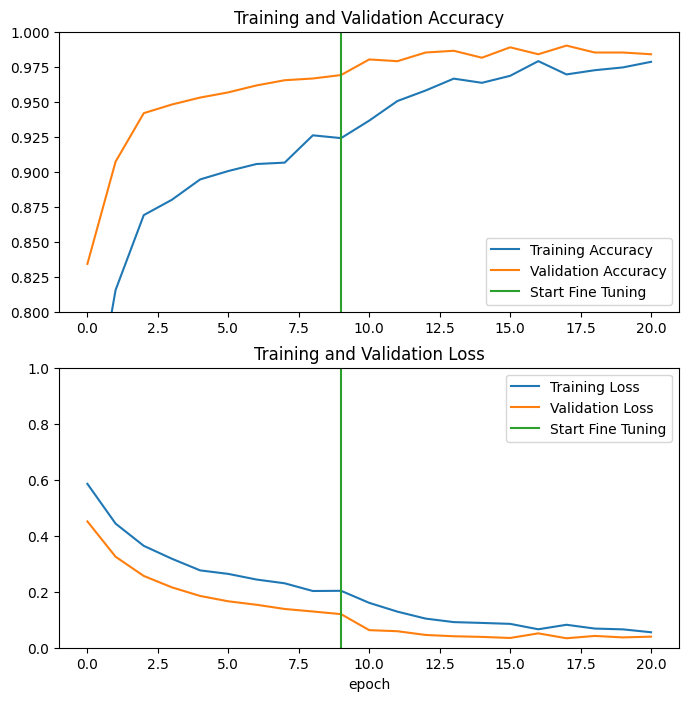

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [37]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)


1/6 [====>.........................] - ETA: 0s - loss: 0.0414 - accuracy: 0.9688


4/6 [===================>..........] - ETA: 0s - loss: 0.0274 - accuracy: 0.9766


6/6 [==============================] - 0s 24ms/step - loss: 0.0240 - accuracy: 0.9792


Test accuracy : 0.9791666865348816


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [0 1 0 0 1 0 1 1 1 0 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0]
Labels:
 [0 1 0 0 1 0 1 1 1 0 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0]


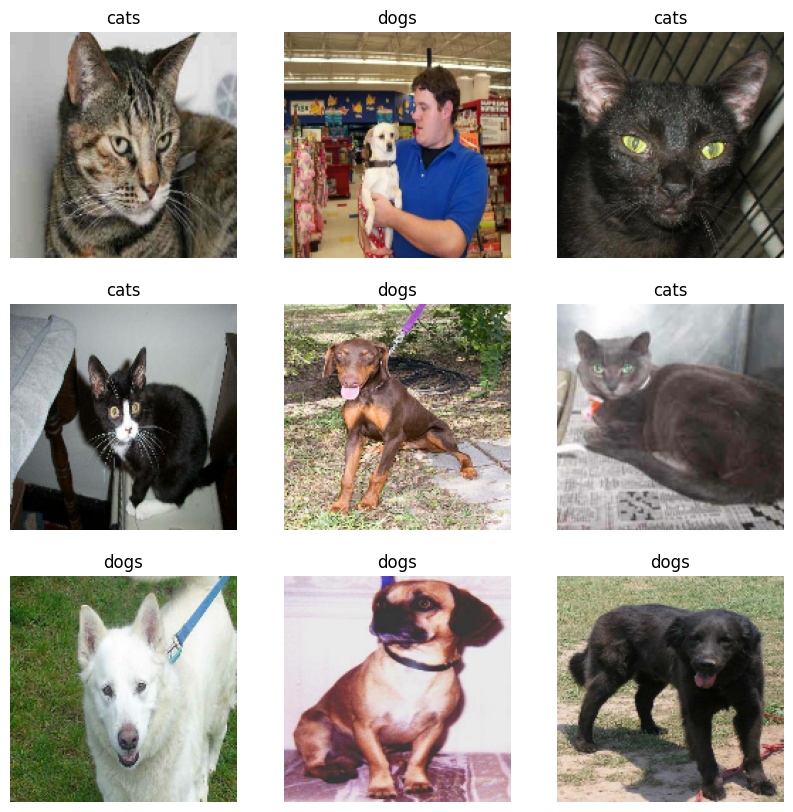

In [38]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
